In [1]:
import os
import sys
import zipfile
import xml.etree.ElementTree as ET
#from xml.dom import minidom

from sqlalchemy import create_engine
import psycopg2
 

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

sys.path.append('../')
%matplotlib inline
from envir import config

## Read CSV File & Convert to Pandas DataFrame

In [2]:
df = pd.read_csv('/gws_gpfs/projects/project-nyc_food_health/workspace/share/toronto_violations.csv')

In [3]:
df.shape

(90361, 17)

In [4]:
df.head()

,Unnamed: 0,row_id,establishment_id,inspection_id,establishment_name,establishmenttype,establishment_address,latitude,longitude,establishment_status,minimum_inspections_peryear,infraction_details,inspection_date,severity,action,court_outcome,amount_fined
0,0,1,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Fail to Hold a Valid Food Handler's Certificat...,2018-06-20,NA - Not Applicable,Notice to Comply,,
1,1,2,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operator fail to properly wash equipment,2018-06-20,M - Minor,Notice to Comply,,
2,2,3,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operator fail to properly wash surfaces in rooms,2018-06-20,M - Minor,Notice to Comply,,
3,3,4,1222579,104277664,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operate food premise - equipment not arranged ...,2018-08-07,M - Minor,Notice to Comply,,
4,4,5,1222579,104277664,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Use handwashing station other than for handwas...,2018-08-07,S - Significant,Corrected During Inspection,,


In [5]:
#df.drop('Unnamed: 0', axis=1, inplace=True)
df['inspection_date'] = pd.to_datetime(df['inspection_date'], format='%Y-%m-%d')

In [6]:
df.head()

,Unnamed: 0,row_id,establishment_id,inspection_id,establishment_name,establishmenttype,establishment_address,latitude,longitude,establishment_status,minimum_inspections_peryear,infraction_details,inspection_date,severity,action,court_outcome,amount_fined
0,0,1,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Fail to Hold a Valid Food Handler's Certificat...,2018-06-20,NA - Not Applicable,Notice to Comply,,
1,1,2,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operator fail to properly wash equipment,2018-06-20,M - Minor,Notice to Comply,,
2,2,3,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operator fail to properly wash surfaces in rooms,2018-06-20,M - Minor,Notice to Comply,,
3,3,4,1222579,104277664,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operate food premise - equipment not arranged ...,2018-08-07,M - Minor,Notice to Comply,,
4,4,5,1222579,104277664,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Use handwashing station other than for handwas...,2018-08-07,S - Significant,Corrected During Inspection,,


In [7]:
df['establishment_status'].unique()

array(['Pass', 'Conditional Pass', 'Closed'], dtype=object)

In [8]:
df['severity'].unique()

array(['NA - Not Applicable', 'M - Minor', 'S - Significant',
       'C - Crucial', nan], dtype=object)

In [9]:
df['establishmenttype'].unique()

array(['Food Take Out', 'Restaurant', 'Cafeteria', 'Commissary',
       'Private Club', 'Child Care - Catered',
       'Food Store (Convenience / Variety)',
       'Child Care - Food Preparation', 'Food Depot', 'Food Court Vendor',
       'Serving Kitchen', 'Banquet Facility', 'Butcher Shop',
       'Food Processing Plant', 'Bakery', 'Supermarket',
       'Other Educational Facility Food Services',
       'Cafeteria - Public Access', 'Nursing Home / Home for the Aged',
       'Ice Cream / Yogurt Vendors', 'Retirement Homes(Licensed)',
       'Institutional Food Service', 'Secondary School Food Services',
       'Fish Shop', 'School Nourishment Program', 'Food Caterer',
       'Cocktail Bar / Beverage Room', 'Bake Shop',
       'Boarding / Lodging Home - Kitchen', 'Flea Market',
       'College/University Food services',
       'Hospitals & Health Facilities', 'Refreshment Stand (Stationary)',
       'Meat Processing Plant', 'Community Kitchen Meal Program',
       'Church Banquet Facil

In [10]:
# Date Range

print(df['inspection_date'].min())
print(df['inspection_date'].max())

2017-10-23 00:00:00
2019-10-23 00:00:00


## Exploratory Data Analysis

In [11]:
pd.options.display.max_colwidth = 100

In [12]:
df[df['severity']=='M - Minor']['infraction_details'][:10]

1                                                                Operator fail to properly wash equipment
2                                                        Operator fail to properly wash surfaces in rooms
3                               Operate food premise - equipment not arranged to permit cleaning - Sec. 9
7                FOOD PREMISE NOT MAINTAINED WITH FOOD HANDLING ROOM IN SANITARY CONDITION - SEC. 7(1)(E)
12    FOOD PREMISE NOT MAINTAINED TO KEEP FOOD-HANDLING ROOM FREE FROM MATERIALS NOT REGULARLY USED - ...
13               FOOD PREMISE NOT MAINTAINED WITH FOOD HANDLING ROOM IN SANITARY CONDITION - SEC. 7(1)(E)
27                                                               Operator fail to properly maintain rooms
28               FOOD PREMISE NOT MAINTAINED WITH FOOD HANDLING ROOM IN SANITARY CONDITION - SEC. 7(1)(E)
29                                      FAIL TO ENSURE EQUIPMENT SURFACE SANITIZED AS NECESSARY - SEC. 22
30                    FOOD PREMISE NOT MAINTAI

In [13]:
df[df['severity']=='S - Significant']['infraction_details'][:10]

4                             Use handwashing station other than for handwashing of employees - Sec. 7(4)
5                                          FAIL TO ENSURE FACILITY SURFACE CLEANED AS NECESSARY - SEC. 22
6                     FAIL TO MAINTAIN HANDWASHING STATIONS (LIQUID SOAP AND PAPER TOWELS) - SEC. 7(3)(C)
10                            Use handwashing station other than for handwashing of employees - Sec. 7(4)
14                                            Fail to clean multi-service articles after use - Sec. 21(1)
16                            OPERATE FOOD PREMISE - FAIL TO KEEP SANITARY FACILITY SANITARY - SEC. 25(2)
34    OPERATE FOOD PREMISE - FAIL TO EQUIP FACILITY WITH CLOTH ROLLER TOWEL, PAPER TOWELS, SINGLE SERV...
37                                         Operator fail to use proper procedure(s) to ensure food safety
53                           FAIL TO PROVIDE TOWELS IN FOOD PREPARATION AREA O. REG  562/90 SEC. 20(1)(C)
54                            USE FOOD PREPARA

In [14]:
df[df['severity']=='C - Crucial']['infraction_details'][:10]

9                         Fail to protect food from contamination or adulteration - Sec. 26(1)
15                        Fail to protect food from contamination or adulteration - Sec. 26(1)
48                           Operator fail to maintain hazardous foods at 60C (140F) or hotter
122                               Operator fail to ensure food is not contaminated/adulterated
147     Refrigerate potentially hazardous foods at internal temperature above 4'C - Sec. 30(a)
227                       Fail to protect food from contamination or adulteration - Sec. 26(1)
338                       Fail to protect food from contamination or adulteration - Sec. 26(1)
339    Food premise maintained in manner permitting adverse effect on food - Sec. 7(1)(a)(iii)
400                               Operator fail to ensure food is not contaminated/adulterated
401                         Operator fail to maintain hazardous food(s) at 4C (40F) or colder.
Name: infraction_details, dtype: object

In [15]:
df[df['severity']=='NA - Not Applicable']['infraction_details'][:10]

0                    Fail to Hold a Valid Food Handler's Certificate. Muncipal Code Chapter 545-157(17)(b)
8              Fail to ensure completion of food handling training by food handler or supervisor - Sec. 32
60     Fail to Ensure the Presence of the Holder of a Valid Food Handlers Certificate - Sec. 545- 157E(...
64     Fail to Ensure the Presence of the Holder of a Valid Food Handler's Certificate. Muncipal Code C...
69                                 Fail to Hold a Valid Food Handler's Certificate  - Sec. 545-157E(17)(b)
70                                 Fail to Hold a Valid Food Handler's Certificate  - Sec. 545-157E(17)(b)
92                                 Fail to Hold a Valid Food Handler's Certificate  - Sec. 545-157E(17)(b)
118                  Fail to Hold a Valid Food Handler's Certificate. Muncipal Code Chapter 545-157(17)(b)
168                                Fail to Hold a Valid Food Handler's Certificate  - Sec. 545-157E(17)(b)
174    Fail to Ensure the Presence of

In [16]:
df_result = df.groupby(df['severity']).count().copy()

df_result.head()

,Unnamed: 0,row_id,establishment_id,inspection_id,establishment_name,establishmenttype,establishment_address,latitude,longitude,establishment_status,minimum_inspections_peryear,infraction_details,inspection_date,action,court_outcome,amount_fined
severity,,,,,,,,,,,,,,,,
C - Crucial,2937,2937,2937,2937,2937,2937,2937,2937,2937,2937,2937,2937,2937,2937,2936,2863
M - Minor,33877,33877,33877,33877,33877,33877,33877,33877,33877,33877,33877,33877,33877,33877,33877,33778
NA - Not Applicable,4396,4396,4396,4396,4396,4396,4396,4396,4396,4396,4396,4396,4396,4396,4396,4286
S - Significant,19870,19870,19870,19870,19870,19870,19870,19870,19870,19870,19870,19870,19870,19870,19869,19723


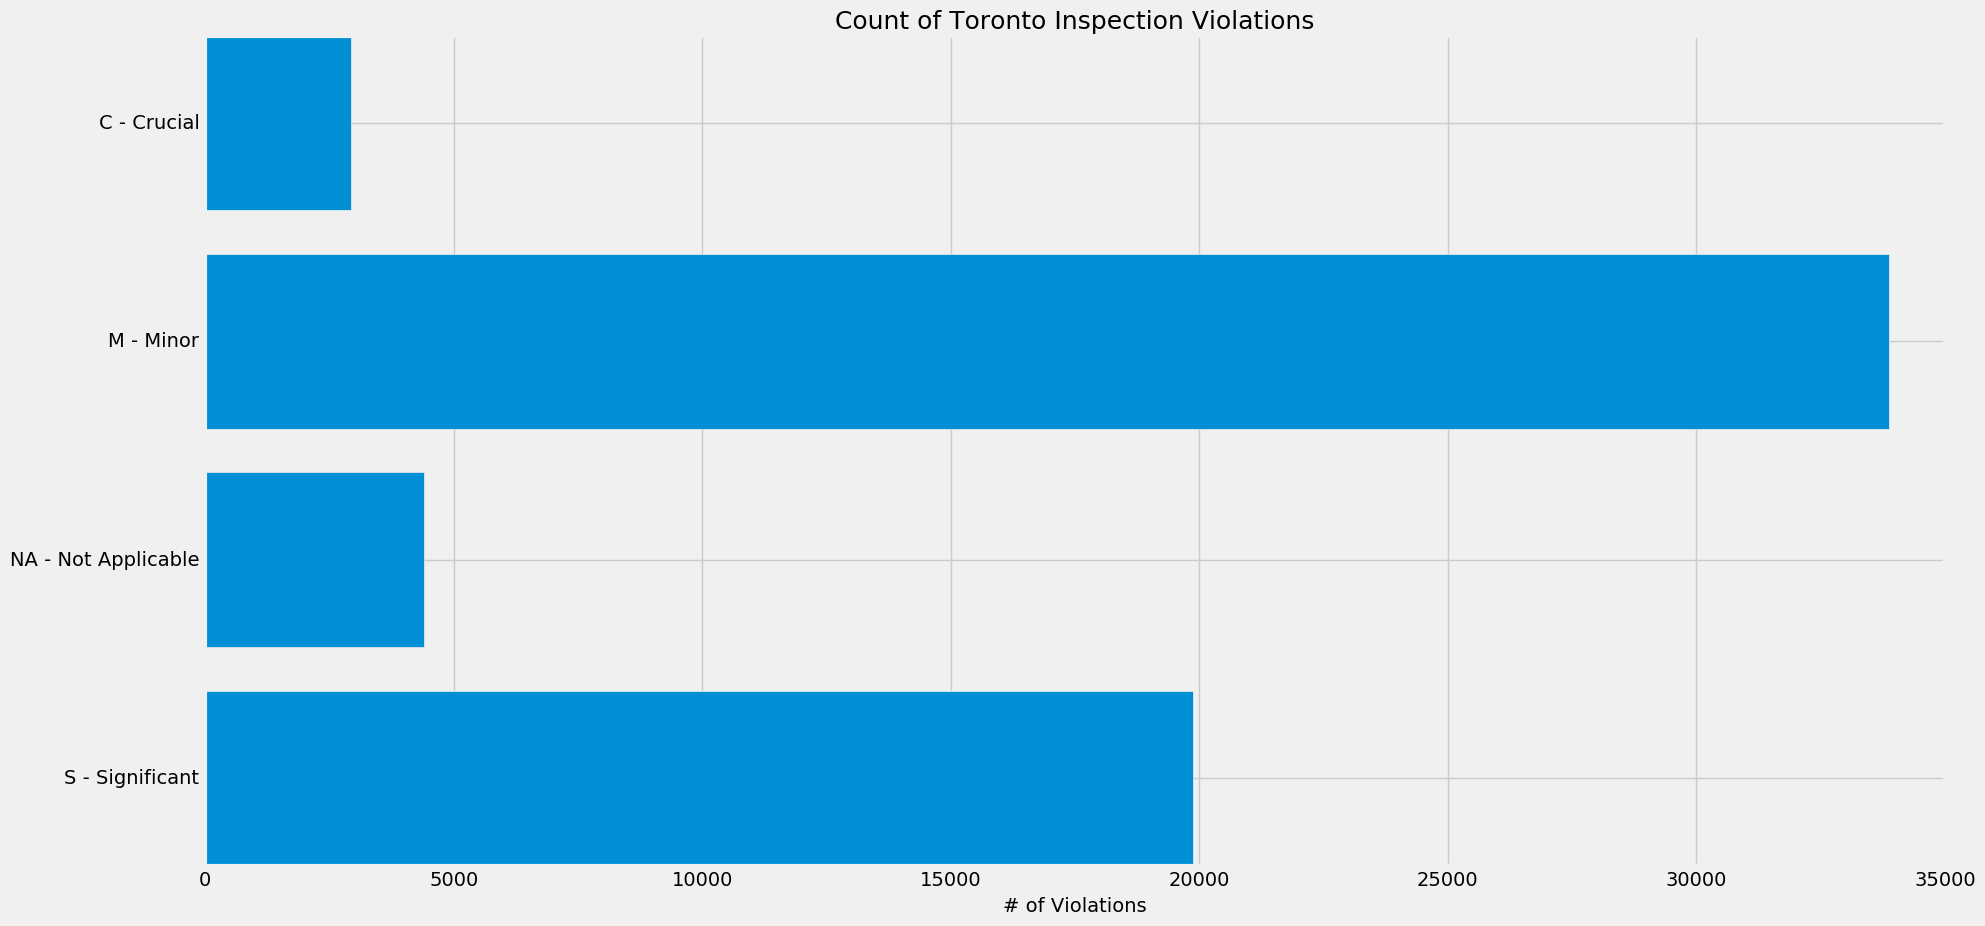

In [52]:
fig, ax = plt.subplots(figsize=(20,10))
plt.style.use('fivethirtyeight')

# Example data

ax.barh(df_result.index, df_result['row_id'], align='center')
ax.set_yticklabels(df_result.index)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('# of Violations', size=14)
ax.set_title('Count of Toronto Inspection Violations', size=18)

fig.savefig('toronto_violation_count.png')

In [18]:
df_inspect = df.drop_duplicates(subset='inspection_id').copy()

In [19]:
df_inspect.head()

,Unnamed: 0,row_id,establishment_id,inspection_id,establishment_name,establishmenttype,establishment_address,latitude,longitude,establishment_status,minimum_inspections_peryear,infraction_details,inspection_date,severity,action,court_outcome,amount_fined
0,0,1,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Fail to Hold a Valid Food Handler's Certificate. Muncipal Code Chapter 545-157(17)(b),2018-06-20,NA - Not Applicable,Notice to Comply,,
3,3,4,1222579,104277664,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operate food premise - equipment not arranged to permit cleaning - Sec. 9,2018-08-07,M - Minor,Notice to Comply,,
5,5,6,1222579,104462048,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Conditional Pass,2,FAIL TO ENSURE FACILITY SURFACE CLEANED AS NECESSARY - SEC. 22,2019-05-09,S - Significant,Notice to Comply,,
11,11,12,1222579,104468700,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,NaN,2019-05-13,NaN,NaN,NaN,NaN
12,12,13,1222579,104552648,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Conditional Pass,2,FOOD PREMISE NOT MAINTAINED TO KEEP FOOD-HANDLING ROOM FREE FROM MATERIALS NOT REGULARLY USED - ...,2019-09-10,M - Minor,Notice to Comply,,


Text(0.5,1,'Count of Toronto Inspection Results')

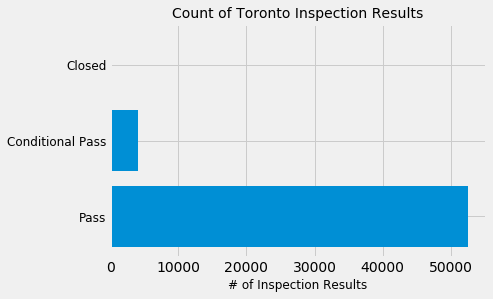

In [20]:
df_passfail = df_inspect.groupby(df_inspect['establishment_status']).count().copy()
plt.style.use('fivethirtyeight')

#Plot
fig, ax = plt.subplots()

ax.barh(df_passfail.index, df_passfail['row_id'], align='center')
ax.set_yticklabels(df_passfail.index, size=12)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('# of Inspection Results', size=12)
ax.set_title('Count of Toronto Inspection Results', size=14)

In [21]:
df_action = df_inspect.groupby(df['action']).count().copy()

df_action.head()

,Unnamed: 0,row_id,establishment_id,inspection_id,establishment_name,establishmenttype,establishment_address,latitude,longitude,establishment_status,minimum_inspections_peryear,infraction_details,inspection_date,severity,action,court_outcome,amount_fined
action,,,,,,,,,,,,,,,,,
Closure Order,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Corrected During Inspection,5963,5963,5963,5963,5963,5963,5963,5963,5963,5963,5963,5963,5963,5963,5963,5963,5963
Education Provided,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Not in Compliance,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
Notice to Comply,21255,21255,21255,21255,21255,21255,21255,21255,21255,21255,21255,21255,21255,21255,21255,21255,21255


Text(0.5,1,'Count of Toronto Post-Inspection Actions')

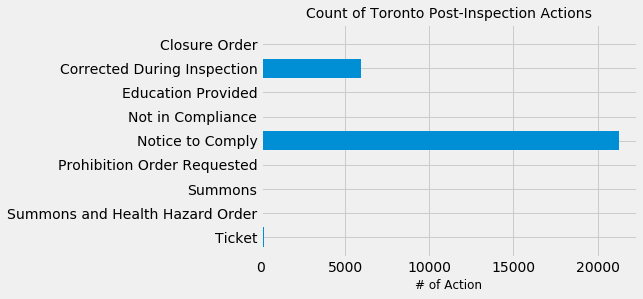

In [22]:
fig, ax = plt.subplots()
plt.style.use('fivethirtyeight')

ax.barh(df_action.index, df_action['row_id'], align='center')
ax.set_yticklabels(df_action.index)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('# of Action', size=12)
ax.set_title('Count of Toronto Post-Inspection Actions', size=14)

In [23]:
t_inspect = df.groupby('inspection_date').inspection_id.nunique().copy()

Text(0,0.5,'Count')

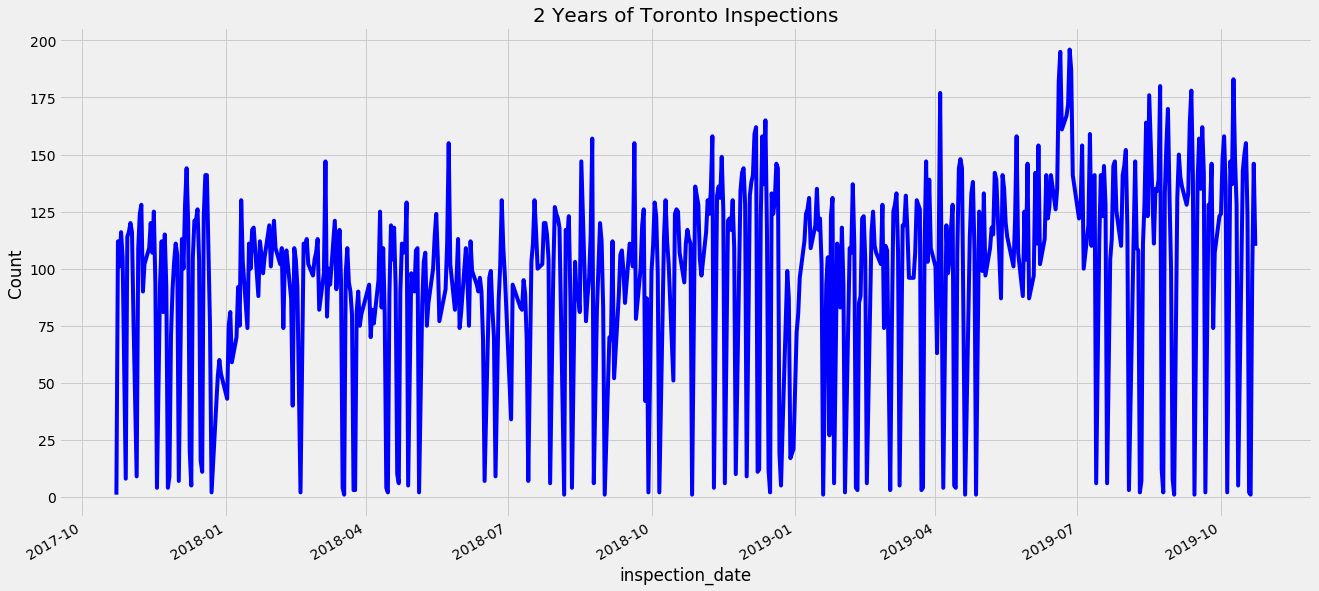

In [24]:
t_inspect.plot(color='blue', figsize=(20, 10))
plt.style.use('fivethirtyeight')
plt.title('2 Years of Toronto Inspections', fontsize=20)
plt.ylabel('Count')

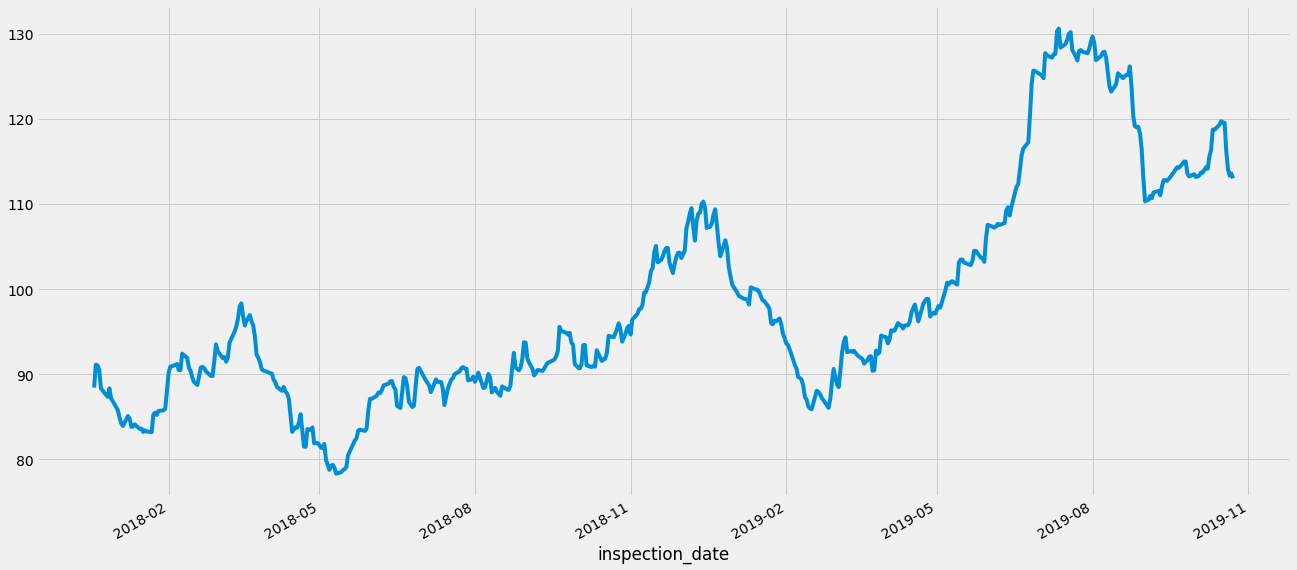

In [25]:
fig, ax = plt.subplots(figsize=(20,10))
plt.style.use('fivethirtyeight')
t_inspect.rolling(window = 52).mean().plot()

fig.savefig('toronto_inspection_trend.png')

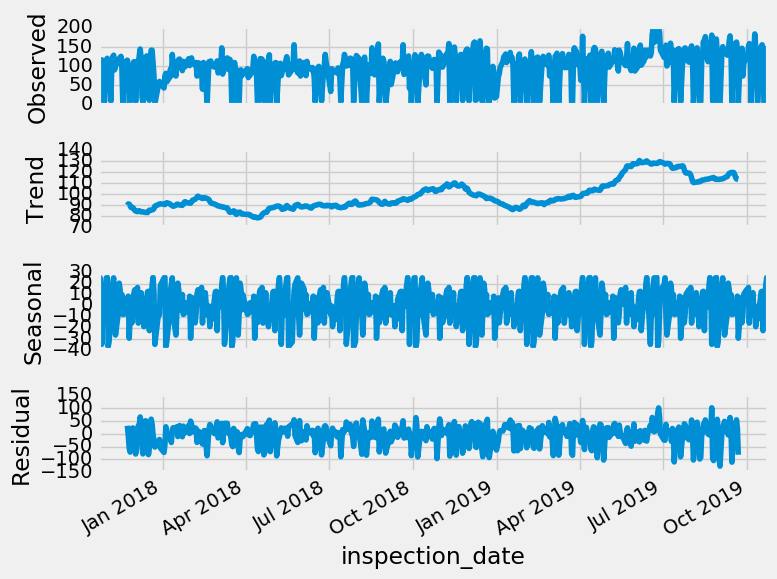

In [53]:
# Seasonal Decomposition

res = sm.tsa.seasonal_decompose(t_inspect,model='additive',freq=52)
res.plot()

plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

In [27]:
# Number of unique inspections 

inspections = list(df['inspection_id'])
unique_inspections = set(inspections)
print(len(unique_inspections))

56741


In [28]:
restaurants = list(df['establishment_id'])
unique_restaurants = set(restaurants)
print(len(unique_restaurants))

16485


## DataFrame Wrangling

In [29]:
df.columns

Index(['Unnamed: 0', 'row_id', 'establishment_id', 'inspection_id',
       'establishment_name', 'establishmenttype', 'establishment_address',
       'latitude', 'longitude', 'establishment_status',
       'minimum_inspections_peryear', 'infraction_details', 'inspection_date',
       'severity', 'action', 'court_outcome', 'amount_fined'],
      dtype='object')

In [30]:
# Make column names lowercase

df.columns = map(str.lower, df.columns)

In [31]:
df.head()

,unnamed: 0,row_id,establishment_id,inspection_id,establishment_name,establishmenttype,establishment_address,latitude,longitude,establishment_status,minimum_inspections_peryear,infraction_details,inspection_date,severity,action,court_outcome,amount_fined
0,0,1,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Fail to Hold a Valid Food Handler's Certificate. Muncipal Code Chapter 545-157(17)(b),2018-06-20,NA - Not Applicable,Notice to Comply,,
1,1,2,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operator fail to properly wash equipment,2018-06-20,M - Minor,Notice to Comply,,
2,2,3,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operator fail to properly wash surfaces in rooms,2018-06-20,M - Minor,Notice to Comply,,
3,3,4,1222579,104277664,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operate food premise - equipment not arranged to permit cleaning - Sec. 9,2018-08-07,M - Minor,Notice to Comply,,
4,4,5,1222579,104277664,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Use handwashing station other than for handwashing of employees - Sec. 7(4),2018-08-07,S - Significant,Corrected During Inspection,,


In [32]:
city = []

for i in range(90361):
    name = 'toronto'
    city.append(name)

In [33]:
df['city'] = city

In [34]:
df.head()

,unnamed: 0,row_id,establishment_id,inspection_id,establishment_name,establishmenttype,establishment_address,latitude,longitude,establishment_status,minimum_inspections_peryear,infraction_details,inspection_date,severity,action,court_outcome,amount_fined,city
0,0,1,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Fail to Hold a Valid Food Handler's Certificate. Muncipal Code Chapter 545-157(17)(b),2018-06-20,NA - Not Applicable,Notice to Comply,,,toronto
1,1,2,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operator fail to properly wash equipment,2018-06-20,M - Minor,Notice to Comply,,,toronto
2,2,3,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operator fail to properly wash surfaces in rooms,2018-06-20,M - Minor,Notice to Comply,,,toronto
3,3,4,1222579,104277664,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operate food premise - equipment not arranged to permit cleaning - Sec. 9,2018-08-07,M - Minor,Notice to Comply,,,toronto
4,4,5,1222579,104277664,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Use handwashing station other than for handwashing of employees - Sec. 7(4),2018-08-07,S - Significant,Corrected During Inspection,,,toronto


In [35]:
df.rename(columns={'establishment_name':'name', 'establishmenttype': 'establishment_type',
                  'establishment_address':'address', 'establishment_status': 'inspection_result'}, inplace=True)

In [36]:
df.head()

,unnamed: 0,row_id,establishment_id,inspection_id,name,establishment_type,address,latitude,longitude,inspection_result,minimum_inspections_peryear,infraction_details,inspection_date,severity,action,court_outcome,amount_fined,city
0,0,1,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Fail to Hold a Valid Food Handler's Certificate. Muncipal Code Chapter 545-157(17)(b),2018-06-20,NA - Not Applicable,Notice to Comply,,,toronto
1,1,2,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operator fail to properly wash equipment,2018-06-20,M - Minor,Notice to Comply,,,toronto
2,2,3,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operator fail to properly wash surfaces in rooms,2018-06-20,M - Minor,Notice to Comply,,,toronto
3,3,4,1222579,104277664,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operate food premise - equipment not arranged to permit cleaning - Sec. 9,2018-08-07,M - Minor,Notice to Comply,,,toronto
4,4,5,1222579,104277664,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Use handwashing station other than for handwashing of employees - Sec. 7(4),2018-08-07,S - Significant,Corrected During Inspection,,,toronto


In [37]:
minor = []
not_applicable = []
significant = []
crucial = []

for i in df['severity']:
    if i == 'M - Minor':
        minor.append(1)
    else:
        minor.append(0)
        
for i in df['severity']:
    if i == 'NA - Not Applicable':
        not_applicable.append(1)
    else:
        not_applicable.append(0)        
        
for i in df['severity']:
    if i == 'C - Crucial':
        crucial.append(1)
    else:
        crucial.append(0)
        
for i in df['severity']:
    if i == 'S - Significant':
        significant.append(1)
    else:
        significant.append(0)

In [38]:
df['minor'] = minor
df['significant'] = significant
df['crucial'] = crucial

In [39]:
df.head()

,unnamed: 0,row_id,establishment_id,inspection_id,name,establishment_type,address,latitude,longitude,inspection_result,...,infraction_details,inspection_date,severity,action,court_outcome,amount_fined,city,minor,significant,crucial
0,0,1,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,...,Fail to Hold a Valid Food Handler's Certificate. Muncipal Code Chapter 545-157(17)(b),2018-06-20,NA - Not Applicable,Notice to Comply,,,toronto,0,0,0
1,1,2,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,...,Operator fail to properly wash equipment,2018-06-20,M - Minor,Notice to Comply,,,toronto,1,0,0
2,2,3,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,...,Operator fail to properly wash surfaces in rooms,2018-06-20,M - Minor,Notice to Comply,,,toronto,1,0,0
3,3,4,1222579,104277664,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,...,Operate food premise - equipment not arranged to permit cleaning - Sec. 9,2018-08-07,M - Minor,Notice to Comply,,,toronto,1,0,0
4,4,5,1222579,104277664,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,...,Use handwashing station other than for handwashing of employees - Sec. 7(4),2018-08-07,S - Significant,Corrected During Inspection,,,toronto,0,1,0


In [40]:
df.drop(['unnamed: 0','establishment_id', 'minimum_inspections_peryear','action',
        'court_outcome','amount_fined', 'severity'],axis=1, inplace=True)

In [41]:
df.head()

,row_id,inspection_id,name,establishment_type,address,latitude,longitude,inspection_result,infraction_details,inspection_date,city,minor,significant,crucial
0,1,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,Fail to Hold a Valid Food Handler's Certificate. Muncipal Code Chapter 545-157(17)(b),2018-06-20,toronto,0,0,0
1,2,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,Operator fail to properly wash equipment,2018-06-20,toronto,1,0,0
2,3,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,Operator fail to properly wash surfaces in rooms,2018-06-20,toronto,1,0,0
3,4,104277664,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,Operate food premise - equipment not arranged to permit cleaning - Sec. 9,2018-08-07,toronto,1,0,0
4,5,104277664,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,Use handwashing station other than for handwashing of employees - Sec. 7(4),2018-08-07,toronto,0,1,0


In [42]:
df.fillna('', inplace=True)

In [43]:
df_inspections = df.groupby(['inspection_id', 'name', 'establishment_type', 'address',
                             'latitude', 'longitude','inspection_result','inspection_date',
                             'city'])['infraction_details'].\
                 agg({'infraction_details': ','.join, 'minor': 'count', 'significant':'count', 'crucial':'count'}).\
                 reset_index()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


In [44]:
df_inspections.drop('inspection_id', axis=1, inplace=True)
df_inspections.rename(columns={'infraction_details':'violations_desc'}, inplace=True)

df_inspections.head()

,name,establishment_type,address,latitude,longitude,inspection_result,inspection_date,city,crucial,minor,violations_desc,significant
0,SHARIF A-708,Hot Dog Cart,135 ST GEORGE ST,43.667572,-79.399840,Pass,2017-11-02,toronto,1,1,,1
1,ALLAN'S PASTRY SHOP,Bakery,3447 KENNEDY RD,43.821249,-79.304594,Pass,2019-08-06,toronto,1,1,,1
2,TUKLEI INTERNATIONAL TRADING LTD,Locker Plant,440 BRIMLEY RD,43.731002,-79.246022,Pass,2018-01-31,toronto,1,1,,1
3,AGNO FOOD & DAIRY PRODUCTS,Food Depot,80 BARBADOS BLVD,43.734857,-79.241387,Pass,2017-12-11,toronto,1,1,,1
4,FRONTIER FRESH,Food Depot,489 BRIMLEY RD,43.734017,-79.245281,Pass,2017-12-29,toronto,1,1,Operator fail to provide washroom supplies,1


In [45]:
#engine = create_engine('postgresql+psycopg2:///yelp_abcs')
#con = engine.connect()

In [46]:
#try:
#    df_inspections.to_sql('toronto_inspections_cleaned', engine, schema= 'clean', index=False)
#except:
#    print('table exists in db')

In [47]:
#df_inspections.to_csv(config.shared+'toronto_inspections_cleaned.csv')